In [1]:
# First I import the common libraries required for
# calculations (on DataFrames) and visualizations :
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# loading the data:
trainingData = pd.read_csv("/home/mozhdeh/Desktop/N26/Data Science Task/2016-09-19_79351_training.csv")

In [3]:
# I take a look at the information about the data first:
trainingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408546 entries, 0 to 408545
Data columns (total 7 columns):
user_id                408546 non-null object
transaction_date       408546 non-null object
transaction_type       408546 non-null object
mcc_group              258324 non-null float64
amount_n26_currency    408546 non-null int64
dataset_transaction    408546 non-null object
dataset_user           408546 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 21.8+ MB


In [4]:
# The data has two columns with int and float values and the rest are
# objects. I get a description summary as well:
trainingData.describe()

,mcc_group,amount_n26_currency
count,258324.000000,408546.000000
mean,4.840166,52.764164
std,4.574400,111.870681
min,1.000000,3.000000
25%,1.000000,7.000000
50%,3.000000,17.000000
75%,7.000000,38.000000
max,17.000000,1166.000000


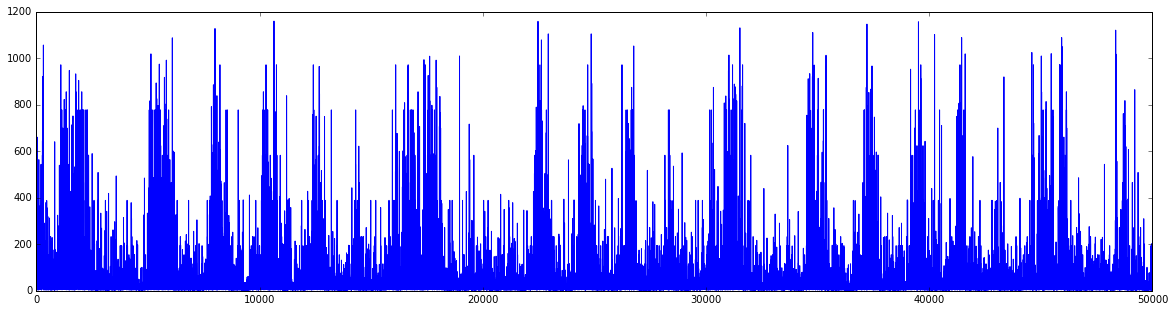

In [6]:
# As well I will have a quick look on a slice of data for getting an impression of the seasonality of the transactions:
%matplotlib inline 
# to activate inline plots.
trainingData['amount_n26_currency'][:50000].plot.line(figsize=(20, 5))

In [7]:
# I load the tables showing the describtions for transaction types
# and mcc_groups :

transactionTypes = pd.read_csv("/home/mozhdeh/Desktop/N26/Data Science Task/transaction_types.csv")

mccGDef = pd.read_csv("/home/mozhdeh/Desktop/N26/Data Science Task/mcc_group_definition.csv")

In [8]:
transactionTypes

,type,explanation,direction,agent
0,AR,Authorization reject,-,Card
1,AE,Authorization expired,In,Card
2,AV,Authorization Reversal,In,Card
3,BBU,Cash26 deposit,In,Partner
4,CT,Credit Transfer,In,Bank Account
5,DI,Dispute,In,Card
6,DR,Debit Reversal,In,Bank Account
7,PF,Credit Card refund by merchant,In,Card
8,PR,Presentment Reversal,In,Card
9,WU,Referral payment,In,Number26


In [9]:
mccGDef

,mcc_group,explanation
0,1,ATM
1,2,Groceries
2,3,Gastronomie
3,4,Shopping/(Fashion)
4,5,"Home and DIY, House Energy"
5,6,Travel/Hotel
6,7,Transport
7,8,Automotive/Gas
8,9,Family/Babies/Children
9,10,Entertainment/Leisure


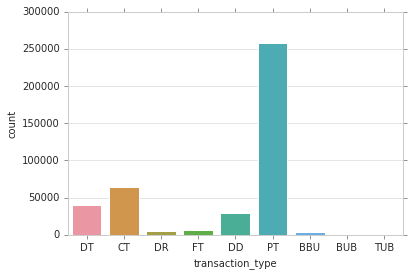

In [10]:
# Then I can have a look at the count plots of the transaction_type
sns.set_style('whitegrid')
sns.countplot(x = 'transaction_type', data = trainingData)

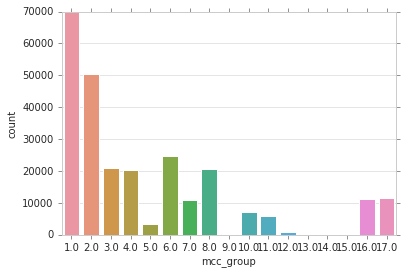

In [11]:
# ... and the countplot for mcc_group:
sns.countplot(x = 'mcc_group', data = trainingData)

/home/mozhdeh/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


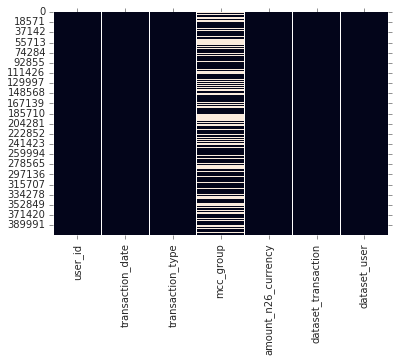

In [12]:
# But taking a look at the mcc_group column using a heatmap, I see that there is some missing data:
sns.heatmap(trainingData.isnull(), cbar=False)

In [13]:
# I will fill the missing values out with the mean value of the whole column. Otherwise one could as well easily
# fill in the missing points with randomly drown values based on mcc_group distribution function.

# Data imputation (using a function):

In [14]:
def impute_mcc(mcc_group):
    #mcc_group = cols
    if  pd.isnull(mcc_group):
        return 4.84016583824964
    else:
        return mcc_group

In [15]:
trainingData['mcc_group'] = trainingData['mcc_group'].apply(impute_mcc)

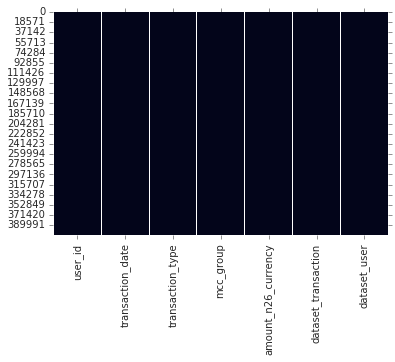

In [16]:
# to check the heatmap again to see that there are no missing values left:
sns.heatmap(trainingData.isnull(), cbar=False)

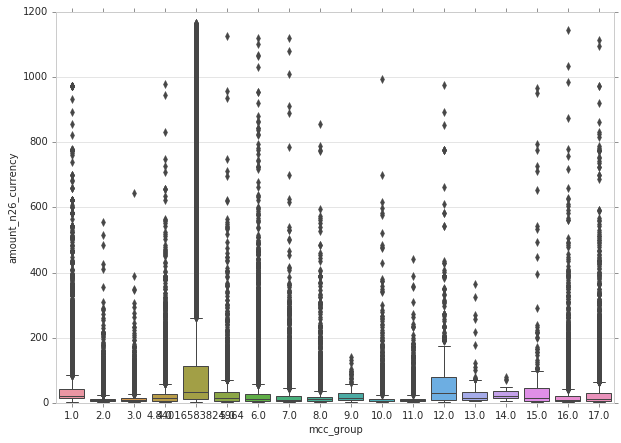

In [17]:
# To get some impression of the relation between the numerical columns, a boxplot is generated:
plt.figure(figsize=(10,7))
sns.boxplot(x='mcc_group', y='amount_n26_currency', data = trainingData)
# It is shown for each card transaction category how much has been transfered, in addition it's mean and std. 

In [18]:
#If I add a column, using the transaction_type table to assign "in" or "out" to each transaction_type,
# then I can countplot and compare the income and expenses in general:

#trainingData['incomeORexpense'] = trainingData['amount_n26_currency'] + trainingData['amount_n26_currency']

# for i in trainingData.index:
#    if (trainingData['transaction_type'][i] == 'AE'|'AV'|'BBU'|'CT'|'DI'|'DR'|'PF'|'PR'|'WU'|'TBU'|'AL'):
#       trainingData['incomeORexpense'][i]='in'
#    else:
#       trainingData['incomeORexpense'][i]='out'  

# Unfortunately, this loop takes so long to run on my laptop, so I just solve the problem in another way.

In [19]:
# The first technique I use for prediction is the so called "seasonal auto-regressive integrated moving
# average" (SARIMA) model. This model is supposed to capture the seasonal changes is the data and as well the general
# regressive and moving average behaviors.

#The required libraries are loaded here:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

In [20]:
# fit model (I only have taken a slice of the data for modeling, because of the slow processing on my laptop).
# The parameters of the model are not well chosen here, but a better fit is easily doable by looking at the correlatio
# -n function and estimating the parameters:
model = SARIMAX(trainingData['amount_n26_currency'][:10000], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()


In [21]:
%matplotlib inline

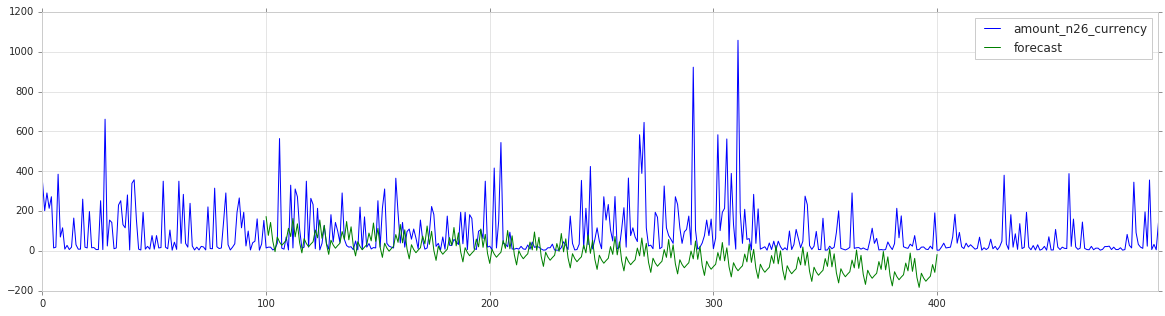

In [22]:
# Here the predictions are made for a subslice of data just to give the ompression how this works (again: for
# bigger slices this could be slow):
trainingData['forecast'] = model_fit.predict(start = 100, end= 400, dynamic= True)
# one better use the whole length of data :len(trainingData['amount_n26_currency']), len(trainingData['amount_n26_currency']))
# And then I plot the data and the forecasted data to compare:
trainingData[['amount_n26_currency', 'forecast']][:500].plot.line(linewidth=1.0, figsize=(20, 5))

In [23]:
# Now to estimate how well the model fits our training data, one can import "metrics" from the library
# "sklearn": 
from sklearn import metrics
metrics.mean_squared_error(trainingData['amount_n26_currency'].iloc[100:400],trainingData['forecast'].iloc[100:400])

36338.89988329988

In [24]:
# Another way to quantify the fitting efficiency is the so called "confusion matrix":
metrics.explained_variance_score(trainingData['amount_n26_currency'].iloc[100:400],trainingData['forecast'].iloc[100:400])

-0.22841758012125046

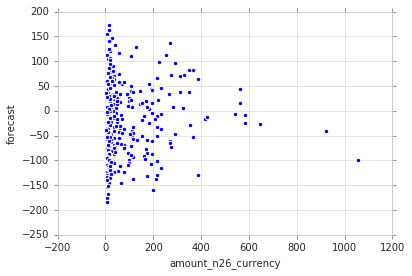

In [25]:
# plotting the scatter plot of the training data and the forecasted one:
plt.scatter(trainingData['amount_n26_currency'].iloc[100:400],trainingData['forecast'].iloc[100:400])
plt.xlabel('amount_n26_currency')
plt.ylabel('forecast')

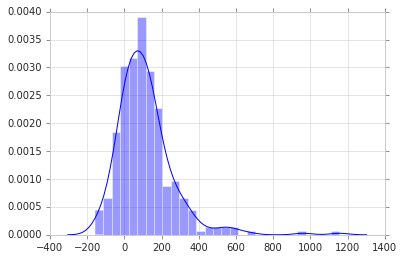

In [26]:
# As well plotting the distribution of the differences between the:
sns.distplot((trainingData['amount_n26_currency'].iloc[100:400]-trainingData['forecast'].iloc[100:400]))

In [33]:
# One can interpret looking at the distribution that the differences are quite small and distributed almost 
# normally (which is a good sign). Although the other quantifiers could be better, but this here is only to
# make an impression of the whole process. 

In [31]:
# Grouping by the months, one could also have an impression about the mean of the numerical columns in each
# month:
import datetime

In [30]:
trainingData = pd.DataFrame(trainingData)
trainingData['transaction_date'] = pd.to_datetime(trainingData['transaction_date'])
trainingData.index = trainingData['transaction_date']
trainingData.resample('M').mean()

,mcc_group,amount_n26_currency,forecast
transaction_date,,,
2016-02-29,4.776055,51.991314,-18.534683
2016-03-31,4.814322,52.927115,NaN
2016-04-30,4.856608,53.218060,NaN
2016-05-31,4.793294,51.721163,NaN
2016-06-30,4.875550,53.037961,NaN
2016-07-31,4.915717,53.611740,NaN


In [34]:
# As the next method, I use Machine Learning algorithms to model the data and make predictions. Below some 
# required libraries are loaded:

# Text feature extraction
# To extract numerical features from text content ('transaction_type' feature), we use the CountVectorizer:
from sklearn.feature_extraction.text import CountVectorizer

# I split the data into training and test sets, so I can test the
# performance of the ML model I use. In order to do this the required
# library is imported from sklearn:
from sklearn.model_selection import train_test_split

# From sklearn, the linear models family, I choose Logistc Regression
# to use as the ML model to predict the income/expenses for the month
# August:
from sklearn.linear_model import LogisticRegression

In [35]:
# first to make the forecast based on the transaction_type, I need to extract the features in this column,
# using CountVectorizor()
vectorizer = CountVectorizer()

In [36]:
x = vectorizer.fit_transform(trainingData['transaction_type'])

In [37]:
# And the data that is going to be predicted:
y = trainingData['amount_n26_currency']

In [38]:
# Now I need to split the data into test and training data based on the features and the target(1/3 is taken:
# here as a test set):
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [39]:
# Now the Logistic Regression, our classification ML model, is applied on the training set:
logReg = LogisticRegression()
logReg.fit(x_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
# Then after fitting the model, the prediction is made on the testing set:
predictions = logReg.predict(x_test)

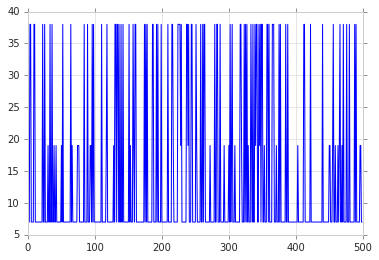

In [52]:
# And then I plot he forecasted data to compare it to the former plot we had from data:
plt.plot(predictions[:500],linewidth=1.0)
# This looks actually that it could be good fit when using a logistic regression (a sigmoid function which
# actually classifies the data to values smaller/bigger than 0.5)

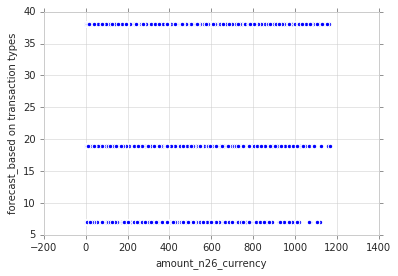

In [53]:
# To check whether our logistic regression model was a good fit to the data, we use a scatter plot as before:
plt.scatter(y_test, predictions)
plt.xlabel('amount_n26_currency')
plt.ylabel('forecast_based on transaction types')
# Looking at the scatter plot, it seems like the classification based on the transaction_types are not bad. At
# least 3 categories are caught, using this model. 

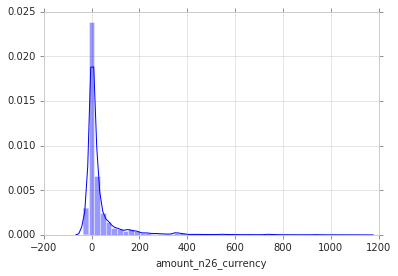

In [54]:
# As well plotting the distribution of the differences between the:
sns.distplot((y_test-predictions))
# Which looks Gaussian distributed and the differences are relatively small.

In [55]:
# Again using Various quantities for evaluating the model:
#1. MSE
metrics.mean_squared_error(y_test,predictions)

13210.103709082601

In [56]:
#2. Confusion matrix:
metrics.explained_variance_score(y_test,predictions)

0.07061001284745572

In [57]:
# Now I go on with using logistic regression to model the data using
# another feature, mcc_group, although I could have used both feature at the same
# modeling, for a better prediction. This could be done easily. On my laptop is quite slow, but a mixture will
# give the best result potentially. 

# The prediction procedure above is repeated here:
x = trainingData[['mcc_group']]

In [58]:
y = trainingData[['amount_n26_currency']]

In [59]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [60]:
logReg = LogisticRegression()

In [61]:
logReg.fit(x_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [62]:
predictions = logReg.predict(x_test)

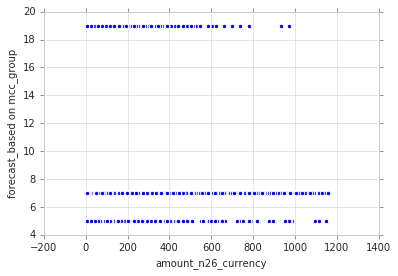

In [63]:
plt.scatter(y_test, predictions)
plt.xlabel('amount_n26_currency')
plt.ylabel('forecast_based on mcc_group')

In [64]:
metrics.explained_variance_score(y_test,predictions)

-0.0032711070610762505

In [78]:
y_test = np.array(y_test)
predictions = np.array(predictions)

In [100]:
flat_list = []
for sublist in y_test:
    for item in sublist:
        flat_list.append(item)

In [102]:
np.array(flat_list)

array([ 11,  35,  27, ..., 175,  12,   8])

In [103]:
predictions

array([7, 7, 7, ..., 7, 7, 7])

In [105]:
np.subtract(flat_list,predictions)

array([  4,  28,  20, ..., 168,   5,   1])

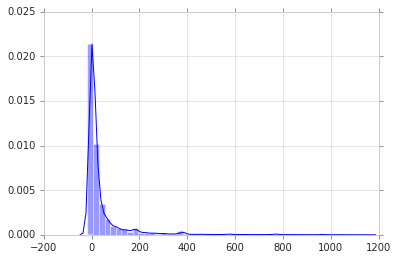

In [106]:
sns.distplot(np.subtract(flat_list,predictions))